# Syntaxin-Binding Protein 1 (STXBP1) and Developmental and epileptic encephalopathy 4 (DEE4)

[Developmental and epileptic encephalopathy 4 (DEE4)](https://omim.org/entry/612164) is a neruological disorder that is typically autosomal dominant, but has been found to also occur as autosomal recessive. Onset typically happens in neonatal or infancy, showing symptoms such as many different types of seizures, developmental regression, impaired intellectual development, hypsarrhythmia, hypotonia, spastic para/quadriplegia, brain hypomyelination, cerebral atrophy, and West syndrome. The syndrome is caused by pathogenic variants in the [STXBP1](https://www.ncbi.nlm.nih.gov/gene/6812) gene.



[Xian et al. (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9166568/) stated that:

>  patients with R406H and R406C mutations were more likely to have a burst suppression pattern on EEG and spastic tetraplegia, and less likely to have ataxia, compared to the rest of the cohort. Additionally, patients with premature termination mutations or deletions in the STXBP1 gene were more likely to have infantile spasms, hypsarrhythmia on EEG, ataxia, hypotonia, and neonatal seizure onset compared to patients with missense mutations.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### STXBP1
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for STXBP1.

In [2]:
gene_symbol = 'STXBP1'
mane_tx_id = 'NM_003165.6'
mane_protein_id = 'NP_003156.1'

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_store_release = '0.1.21' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')


cohort_creator = configure_caching_cohort_creator(hpo)
"""
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
"""
ppkt_dir = "../../../phenopacket-store/notebooks/STXBP1/phenopackets"
cohort, qc = load_phenopacket_folder(pp_directory=ppkt_dir, cohort_creator=cohort_creator)

print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Loaded 463 phenopackets
Individuals Processed: 462individuals [00:00, 1183.56individuals/s]
Loaded 462 individuals
Validated under permissive policy
No errors or warnings were found


In [7]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,230
Absent speech,HP:0001344,152
Infantile spasms,HP:0012469,143
Hypsarrhythmia,HP:0002521,120
"Intellectual disability, severe",HP:0010864,106
Inability to walk,HP:0002540,93
Generalized tonic seizure,HP:0010818,92
Multifocal epileptiform discharges,HP:0010841,86
Bilateral tonic-clonic seizure,HP:0002069,77
EEG with burst suppression,HP:0010851,75


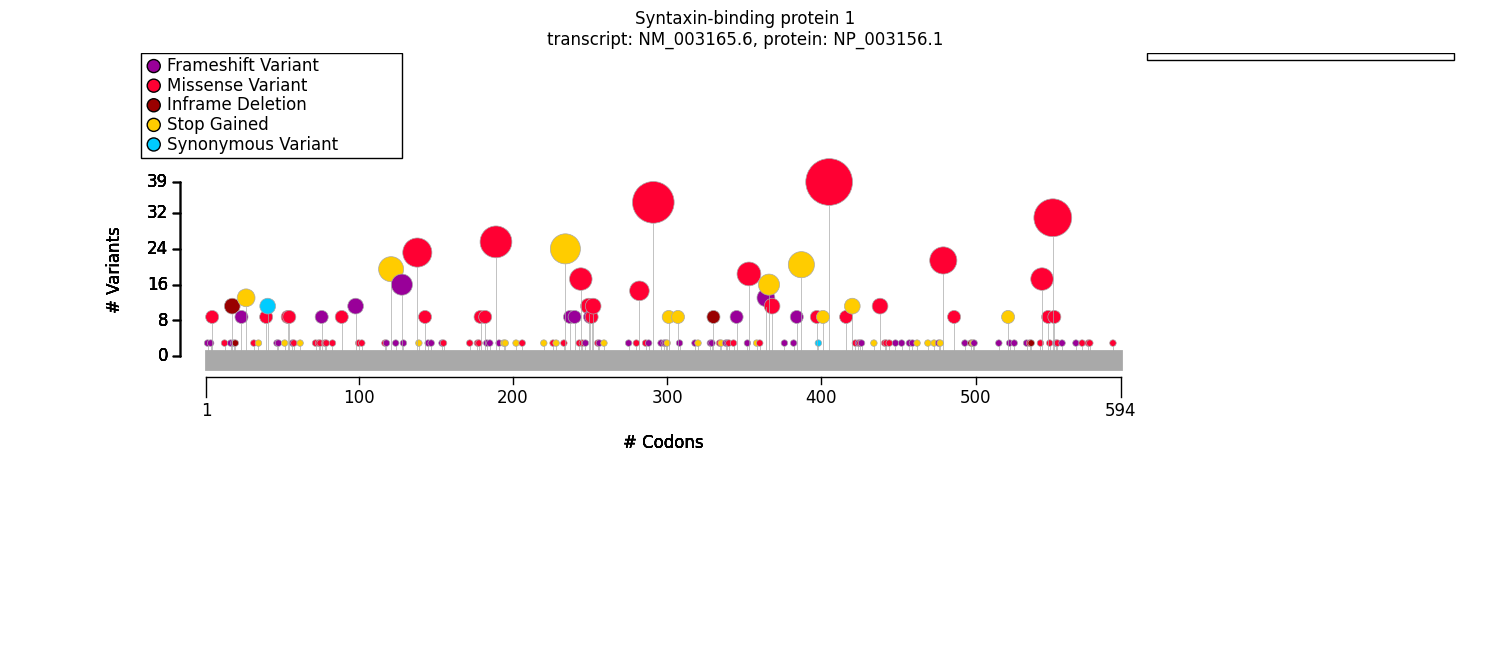

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


stxbp1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
stxbp1_fig.tight_layout()

In [9]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(report)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
9_127675910_127675910_G_A,c.1217G>A,p.Arg406His,14,missense,19
9_127675909_127675909_C_T,c.1216C>T,p.Arg406Cys,14,missense,19
9_127668160_127668160_G_A,c.875G>A,p.Arg292His,10,missense,18
9_127682509_127682509_C_T,c.1651C>T,p.Arg551Cys,18,missense,18
9_127661192_127661192_C_T,c.416C>T,p.Pro139Leu,6,missense,12
9_127663343_127663343_C_T,c.568C>T,p.Arg190Trp,7,missense,11
9_127678510_127678510_C_T,c.1439C>T,p.Pro480Leu,16,missense,10
9_127675855_127675855_C_T,c.1162C>T,p.Arg388Ter,14,stop gained,10
9_127668159_127668159_C_T,c.874C>T,p.Arg292Cys,10,missense,10
9_127661140_127661140_C_T,c.364C>T,p.Arg122Ter,6,stop gained,9


# Genotype-Phenotype Correlation (GPC) Analysis

In [10]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

## Genotype predicate

Test Missense variants vs. the others.


In [ ]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

## Summarize the HPO terms

In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense            Other  \
                                                      Count Percent    Count   
EEG with generalized epileptiform discharges [H...  100/100    100%    99/99   
Interictal epileptiform activity [HP:0011182]       169/169    100%  140/140   
Interictal EEG abnormality [HP:0025373]             171/171    100%  144/144   
EEG abnormality [HP:0002353]                        178/178    100%  155/155   
Neurodevelopmental abnormality [HP:0012759]         236/236    100%  201/201   
Neurodevelopmental delay [HP:0012758]               213/213    100%  184/184   
Abnormal muscle tone [HP:0003808]                   112/112    100%  115/115   
Global developmental delay [HP:0001263]             175/175    100%  155/155   
Abnormal speech pattern [HP:0002167]                116/116    100%  102/102   
Abnormal communication [HP:0034434]                 123/123    100%  107/107   
Delayed speech and language development [HP:000...  114/114    100%  100/100   
Language impairment [HP:0002463]                    118/118    100%  103/103   
Seizure [HP:0001250]                                221/221    100%  188/188   
Epileptic spasm [HP:0011097]                          92/92    100%    99/99   
Motor seizure [HP:0020219]                          161/161    100%  143/143   
Focal-onset seizure [HP:0007359]                    124/124    100%  103/103   
Intellectual disability [HP:0001249]                109/109    100%  100/100   
EEG with focal epileptiform discharges [HP:0011...  108/108    100%    86/86   

Allele group                                                                   \
                                                   Percent Corrected p values   
EEG with generalized epileptiform discharges [H...    100%                1.0   
Interictal epileptiform activity [HP:0011182]         100%                1.0   
Interictal EEG abnormality [HP:0025373]               100%                1.0   
EEG abnormality [HP:0002353]                          100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Delayed speech and language development [HP:000...    100%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Epileptic spasm [HP:0011097]                          100%                1.0   
Motor seizure [HP:0020219]                            100%                1.0   
Focal-onset seizure [HP:0007359]                      100%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   
EEG with focal epileptiform discharges [HP:0011...    100%                1.0   

Allele group                                                 
                                                   p values  
EEG with generalized epileptiform discharges [H...      1.0  
Interictal epileptiform activity [HP:0011182]           1.0  
Interictal EEG abnormality [HP:0025373]                 1.0  
EEG abnormality [HP:0002353]                            1.0  
Neurodevelopmental abnormality [HP:0012759]             1.0  
Neurodevelopmental delay [HP:0012758]                   1.0  
Abnormal muscle tone [HP:0003808]                       1.0  
Global developmental delay [HP:0001263]                 1.0  
Abnormal speech pattern [HP:0002167]                    1.0  
Abnormal communication [HP:0034434]                     1.0  
Delayed speech and language develo

In [14]:
r406h = VariantPredicates.variant_key("9_127675910_127675910_G_A") #c.1217G>A	p.Arg406His	
r406c = VariantPredicates.variant_key("9_127675909_127675909_C_T") #9_127675909_127675909_C_T

r406 = VariantPredicates.any((r406c, r406h))

r406_predicate = monoallelic_predicate(
    a_predicate=r406,
    b_predicate=~r406,
    a_label="Arg406 Variants",
    b_label="Other"
)

r406_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=r406_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=r406_result)

Allele group                                       Arg406 Variants          \
                                                             Count Percent   
EEG with generalized epileptiform discharges [H...           25/25    100%   
Interictal epileptiform activity [HP:0011182]                30/30    100%   
Interictal EEG abnormality [HP:0025373]                      31/31    100%   
EEG abnormality [HP:0002353]                                 33/33    100%   
Neurodevelopmental abnormality [HP:0012759]                  36/36    100%   
Neurodevelopmental delay [HP:0012758]                        31/31    100%   
Abnormal muscle tone [HP:0003808]                            19/19    100%   
Global developmental delay [HP:0001263]                      25/25    100%   
Abnormal speech pattern [HP:0002167]                         21/21    100%   
Abnormal communication [HP:0034434]                          21/21    100%   
Delayed speech and language development [HP:000...           21/21    100%   
Language impairment [HP:0002463]                             21/21    100%   
Seizure [HP:0001250]                                         34/34    100%   
Epileptic spasm [HP:0011097]                                 17/17    100%   
Motor seizure [HP:0020219]                                   25/25    100%   
Focal-onset seizure [HP:0007359]                             16/16    100%   
Intellectual disability [HP:0001249]                         16/16    100%   
EEG with focal epileptiform discharges [HP:0011...           14/14    100%   

Allele group                                          Other          \
                                                      Count Percent   
EEG with generalized epileptiform discharges [H...  174/174    100%   
Interictal epileptiform activity [HP:0011182]       279/279    100%   
Interictal EEG abnormality [HP:0025373]             284/284    100%   
EEG abnormality [HP:0002353]                        300/300    100%   
Neurodevelopmental abnormality [HP:0012759]         401/401    100%   
Neurodevelopmental delay [HP:0012758]               366/366    100%   
Abnormal muscle tone [HP:0003808]                   208/208    100%   
Global developmental delay [HP:0001263]             305/305    100%   
Abnormal speech pattern [HP:0002167]                197/197    100%   
Abnormal communication [HP:0034434]                 209/209    100%   
Delayed speech and language development [HP:000...  193/193    100%   
Language impairment [HP:0002463]                    200/200    100%   
Seizure [HP:0001250]                                375/375    100%   
Epileptic spasm [HP:0011097]                        174/174    100%   
Motor seizure [HP:0020219]                          279/279    100%   
Focal-onset seizure [HP:0007359]                    211/211    100%   
Intellectual disability [HP:0001249]                193/193    100%   
EEG with focal epileptiform discharges [HP:0011...  180/180    100%   

Allele group                                                                    
                                                   Corrected p values p values  
EEG with generalized epileptiform discharges [H...                1.0      1.0  
Interictal epileptiform activity [HP:0011182]                     1.0      1.0  
Interictal EEG abnormality [HP:0025373]                           1.0      1.0  
EEG abnormality [HP:0002353]                                      1.0      1.0  
Neurodevelopmental abnormality [HP:0012759]                       1.0      1.0  
Neurodevelopmental delay [HP:0012758]                             1.0      1.0  
Abnormal muscle tone [HP:0003808]                                 1.0      1.0  
Global developmental delay [HP:0001263]                           1.0      1.0  
Abnormal speech pattern [HP:0002167]                              1.0      1.0  
Abnormal communication [HP:0034434]                               1.0      1.0  
Delayed speech and language development [HP:00

In [ ]:
report_half = 
report_half

What is the genotype group                         No allele          \
                                                       Count Percent   
EEG with generalized polyspikes [HP:0012001]             4/5     80%   
Focal aware seizure [HP:0002349]                         0/5      0%   
Multifocal seizures [HP:0031165]                        5/10     50%   
EEG with temporal focal spikes [HP:0012018]              8/9     89%   
EEG with temporal epileptiform discharges [HP:0...     12/13     92%   
...                                                      ...     ...   
Bilateral tonic-clonic seizure with focal onset...      9/14     64%   
Nocturnal seizures [HP:0031951]                          3/8     38%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...       3/4     75%   
EEG with parietal epileptiform discharges [HP:0...       2/3     67%   
Focal behavior arrest seizure [HP:0011173]               2/7     29%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
EEG with generalized polyspikes [HP:0012001]               0/2      0%   
Focal aware seizure [HP:0002349]                           2/4     50%   
Multifocal seizures [HP:0031165]                         10/12     83%   
EEG with temporal focal spikes [HP:0012018]                2/4     50%   
EEG with temporal epileptiform discharges [HP:0...         4/6     67%   
...                                                        ...     ...   
Bilateral tonic-clonic seizure with focal onset...         5/7     71%   
Nocturnal seizures [HP:0031951]                            2/4     50%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...         2/4     50%   
EEG with parietal epileptiform discharges [HP:0...         2/4     50%   
Focal behavior arrest seizure [HP:0011173]                 0/2      0%   

What is the genotype group                                             \
                                                   Corrected p values   
EEG with generalized polyspikes [HP:0012001]                 0.992151   
Focal aware seizure [HP:0002349]                             0.992151   
Multifocal seizures [HP:0031165]                             0.992151   
EEG with temporal focal spikes [HP:0012018]                  0.992151   
EEG with temporal epileptiform discharges [HP:0...           0.992151   
...                                                               ...   
Bilateral tonic-clonic seizure with focal onset...           1.000000   
Nocturnal seizures [HP:0031951]                              1.000000   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...           1.000000   
EEG with parietal epileptiform discharges [HP:0...           1.000000   
Focal behavior arrest seizure [HP:0011173]                   1.000000   

What is the genotype group                                    
                                                    p values  
EEG with generalized polyspikes [HP:0012001]        0.142857  
Focal aware seizure [HP:0002349]                    0.166667  
Multifocal seizures [HP:0031165]                    0.171827  
EEG with temporal focal spikes [HP:0012018]         0.202797  
EEG with temporal epileptiform discharges [HP:0...  0.221878  
...                                                      ...  
Bilateral tonic-clonic seizure with focal onset...  1.000000  
Nocturnal seizures [HP:0031951]                     1.000000  
EEG with spike-wave complexes (<2.5 Hz) [HP:001...  1.000000  
EEG with parietal epileptiform discharges [HP:0...  1.000000  
Focal behavior arrest seizure [HP:0011173]          1.000000  

[100 rows x 6 columns]

In [ ]:
exon_14 = VariantPredicates.exon(14, mane_tx_id)
gt_14_predicate = autosomal_dominant(exon_14)

In [ ]:
result_14 = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_14_predicate,
    pheno_predicates=pheno_predicates,
)

In [ ]:
report_14 = summarize_hpo_analysis(hpo=hpo, result=result_14)
report_14

What is the genotype group                         No allele          \
                                                       Count Percent   
Periventricular leukomalacia [HP:0006970]                0/7      0%   
Focal hemiclonic seizure [HP:0006813]                   4/11     36%   
Abnormal periventricular white matter morpholog...       2/9     22%   
Focal motor seizure with version [HP:0011175]            2/9     22%   
Focal impaired awareness autonomic seizure [HP:...      3/10     30%   
...                                                      ...     ...   
Hyperintensity of cerebral white matter on MRI ...      5/12     42%   
Focal cortical dysplasia type I [HP:0032047]             2/9     22%   
Focal cortical dysplasia [HP:0032046]                   4/11     36%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...       4/7     57%   
EEG with parietal epileptiform discharges [HP:0...       3/6     50%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Periventricular leukomalacia [HP:0006970]                  2/3     67%   
Focal hemiclonic seizure [HP:0006813]                      3/3    100%   
Abnormal periventricular white matter morpholog...         3/4     75%   
Focal motor seizure with version [HP:0011175]              1/1    100%   
Focal impaired awareness autonomic seizure [HP:...         1/1    100%   
...                                                        ...     ...   
Hyperintensity of cerebral white matter on MRI ...         1/2     50%   
Focal cortical dysplasia type I [HP:0032047]               0/1      0%   
Focal cortical dysplasia [HP:0032046]                      0/1      0%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...         1/1    100%   
EEG with parietal epileptiform discharges [HP:0...         1/1    100%   

What is the genotype group                                             \
                                                   Corrected p values   
Periventricular leukomalacia [HP:0006970]                         1.0   
Focal hemiclonic seizure [HP:0006813]                             1.0   
Abnormal periventricular white matter morpholog...                1.0   
Focal motor seizure with version [HP:0011175]                     1.0   
Focal impaired awareness autonomic seizure [HP:...                1.0   
...                                                               ...   
Hyperintensity of cerebral white matter on MRI ...                1.0   
Focal cortical dysplasia type I [HP:0032047]                      1.0   
Focal cortical dysplasia [HP:0032046]                             1.0   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...                1.0   
EEG with parietal epileptiform discharges [HP:0...                1.0   

What is the genotype group                                    
                                                    p values  
Periventricular leukomalacia [HP:0006970]           0.066667  
Focal hemiclonic seizure [HP:0006813]               0.192308  
Abnormal periventricular white matter morpholog...  0.216783  
Focal motor seizure with version [HP:0011175]       0.300000  
Focal impaired awareness autonomic seizure [HP:...  0.363636  
...                                                      ...  
Hyperintensity of cerebral white matter on MRI ...  1.000000  
Focal cortical dysplasia type I [HP:0032047]        1.000000  
Focal cortical dysplasia [HP:0032046]               1.000000  
EEG with spike-wave complexes (<2.5 Hz) [HP:001...  1.000000  
EEG with parietal epileptiform discharges [HP:0...  1.000000  

[87 rows x 6 columns]